In [1]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [2]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 98% 319M/325M [00:10<00:00, 31.9MB/s]
100% 325M/325M [00:10<00:00, 32.8MB/s]


In [3]:
%%capture
!unzip \*.zip && rm *.zip &> /dev/null

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

In [5]:
test_dir = '/content/test'
training_dir = '/content/train'

In [6]:
training_benign_dir = os.path.join(training_dir,'benign')
training_malignant_dir = os.path.join(training_dir,'malignant')
test_benign_dir = os.path.join(test_dir,'benign')
test_malignant_dir = os.path.join(test_dir,'malignant')

In [7]:
print('Total training image for benign are :',len(os.listdir(training_benign_dir)))
print('Total training image for malignant are :',len(os.listdir(training_malignant_dir)))
print('Total test image for benign are :',len(os.listdir(test_benign_dir)))
print('Total test image for malignant are :',len(os.listdir(test_malignant_dir)))

Total training image for benign are : 1440
Total training image for malignant are : 1197
Total test image for benign are : 360
Total test image for malignant are : 300


In [8]:
training_benign_fnames = os.listdir(training_benign_dir)
print(training_benign_fnames[:10])

training_malignant_fnames = os.listdir(training_malignant_dir)
training_malignant_fnames.sort()
print(training_malignant_fnames[:10])

['980.jpg', '1585.jpg', '1726.jpg', '1095.jpg', '948.jpg', '1240.jpg', '39.jpg', '1084.jpg', '1178.jpg', '1156.jpg']
['10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1004.jpg', '1006.jpg', '1008.jpg', '101.jpg', '1010.jpg']


In [9]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

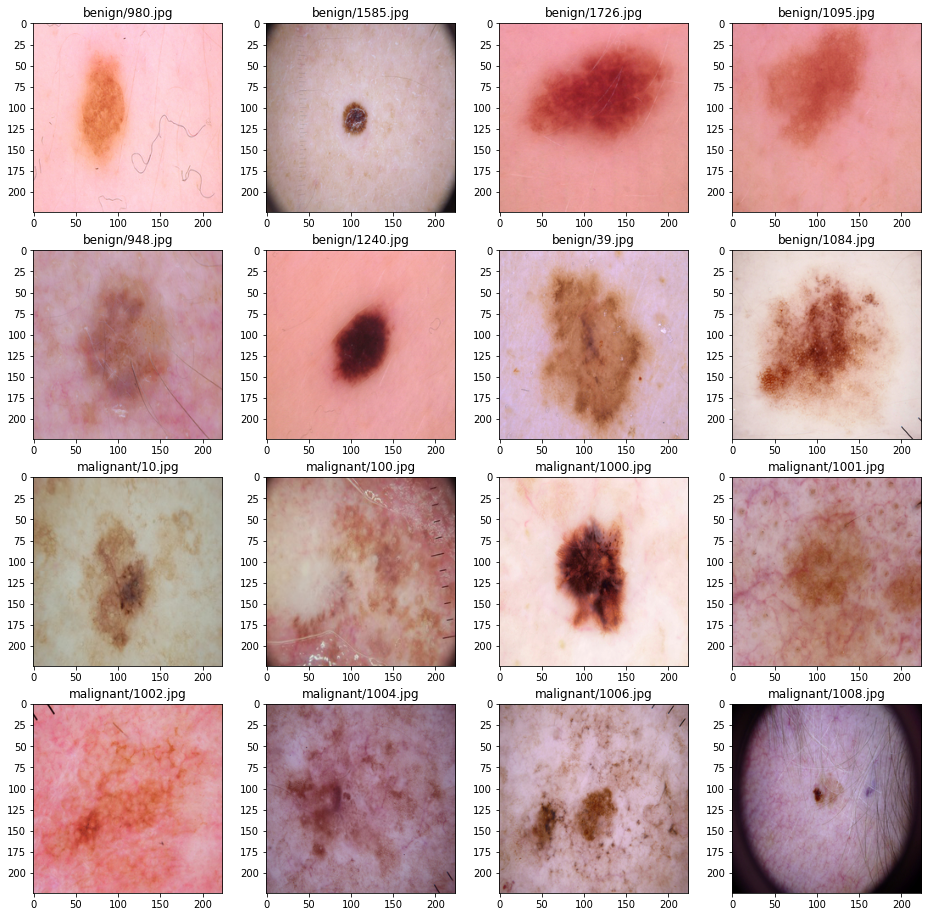

In [10]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_benign_pix = [os.path.join(training_benign_dir, fname) 
                for fname in training_benign_fnames[pic_index-8:pic_index]]
next_malignant_pix = [os.path.join(training_malignant_dir, fname) 
                for fname in training_malignant_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_benign_pix+next_malignant_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  #sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(img_path[15:])

plt.show()


In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_genrator = train_datagen.flow_from_directory(
    training_dir,
    target_size = (224,224),
    batch_size = 20,
    class_mode = 'binary'

)

test_genrator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [13]:
convo_base = ResNet50(weights='imagenet',
                   include_top=False,
                   input_shape=(224,224,3),
                   classes = 2
                   )

94781440/94765736 [==============================] - 3s 0us/step


In [14]:
convo_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
model = models.Sequential()

In [16]:
model.add(convo_base)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 75,231,617
Trainable params: 75,178,497
Non-trainable params: 53,120
_______________________________________

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              metrics = ['acc'],
               loss=tf.keras.losses.BinaryCrossentropy())

In [20]:
check_point = tf.keras.callbacks.ModelCheckpoint(filepath="/content/transfer_l_mode.h5",
                                         monitor="val_acc",
                                         mode="max",
                                         save_best_only=True,)

In [21]:
trained_model = model.fit(
    train_genrator,
    validation_data= test_genrator,
    epochs = 100,
    steps_per_epoch=131,
    #validation_steps=33
    callbacks = [check_point]
    )

Epoch 1/100
131/131 [==============================] - 37s 283ms/step - loss: 0.5854 - acc: 0.7612 - val_loss: 0.6968 - val_acc: 0.4545


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
131/131 [==============================] - 38s 286ms/step - loss: 0.5884 - acc: 0.7616 - val_loss: 0.6943 - val_acc: 0.4545
Epoch 3/100
131/131 [==============================] - 37s 281ms/step - loss: 0.5587 - acc: 0.7837 - val_loss: 0.6928 - val_acc: 0.5545
Epoch 4/100
131/131 [==============================] - 37s 281ms/step - loss: 0.4682 - acc: 0.7925 - val_loss: 0.6881 - val_acc: 0.5818
Epoch 5/100
131/131 [==============================] - 37s 281ms/step - loss: 0.4380 - acc: 0.7998 - val_loss: 0.5984 - val_acc: 0.7061
Epoch 6/100
131/131 [==============================] - 37s 282ms/step - loss: 0.4331 - acc: 0.7994 - val_loss: 0.5569 - val_acc: 0.6970
Epoch 7/100
131/131 [==============================] - 37s 282ms/step - loss: 0.4143 - acc: 0.8151 - val_loss: 0.4862 - val_acc: 0.7742
Epoch 8/100
131/131 [==============================] - 37s 282ms/step - loss: 0.4102 - acc: 0.8109 - val_loss: 0.4213 - val_acc: 0.7864
Epoch 9/100
131/131 [===========================

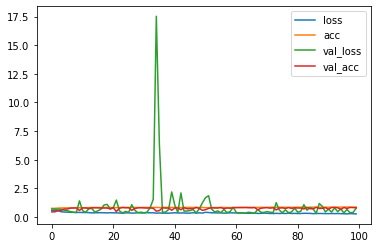

In [22]:
pd.DataFrame(trained_model.history).plot()

In [23]:
model.evaluate(test_genrator)

33/33 [==============================] - 2s 58ms/step - loss: 0.7714 - acc: 0.8106


[0.771437406539917, 0.810606062412262]